In [2]:
import numpy as np
import scipy.linalg as linalg
import matplotlib.pyplot as plt
import math

## Question 1 (EKF and UKF for Nonlinear Wiener velocity model)
### a) Form the corresponding state-space model:

### The Wiener velocity model has $\mathbf{x} = [p, \dot{p}]$ (Derivation are in lecture 8 pages 28 - 30)
$$
\mathbf{x}_n = \begin{bmatrix}1 & \Delta t\\ 0 & 1 \end{bmatrix} \mathbf{x}_{n-1} + \mathbf{q}_n, \qquad \mathbf{q}_n \sim \mathcal{N}
\bigg(\begin{bmatrix} 0 \\ 0 \end{bmatrix} , q_w \begin{bmatrix}\frac{\Delta t^3}{3} & \frac{\Delta t^2}{2}\\ \frac{\Delta t^2}{2} & \Delta t \end{bmatrix} \bigg)$$
### The measurement model is given as
$$
y_n = \sin(x_{1,n}) + r_n. 
$$



### b) Derive the Jacobian of the measurement model function needed in the EKF update. Deduce that the prediction step of the EKF reduces to that of the conventional Kalman filter.

### The Jacobian of $g(\mathbf{x}) = \sin(x_1)$ is $\mathbf{G}(\mathbf{x}) = \begin{bmatrix} \frac{\partial g(\mathbf{x})}{\partial x_1} & \frac{\partial g(\mathbf{x})}{\partial x_2} \end{bmatrix} =  \begin{bmatrix} \cos(x_1) & 0 \end{bmatrix}$. Note that $\mathbf{x} = [p, \dot{p}] = [x_1, x_2]$

### Because the dynamics is linear Gaussian, the prediction step is just the linear Kalman prediction.
$$
x_n = F x_{n-1} + q_n
$$
### In the prediction step of Extended Kalman filter we have:
$$
\hat{x}_{n \mid n-1} = f(\hat{x}_{n-1 \mid n-1})\\
$$
$$
P_{n \mid n-1} = F_x P_{n-1 \mid n-1} F_x^T + Q_n
$$
### Because the dynamics is linear Gaussian $f(\hat{x}_{n-1 \mid n-1}) = F \hat{x}_{n-1 \mid n-1} $ and $F_x = F$

In [160]:
# data simulation

In [7]:
dt  = 0.1
sigma2_w = 0.1
F_wiener = np.array([ [1, dt],
                      [0, 1] ])
Q_wiener = sigma2_w * np.array([ [dt**3/3, dt**2/2],
                                [dt**2/2, dt] ])

In [8]:
# Simulate the dynamic model
def wiener_dynamic(m0, P0, steps, F, Q):
    nx = m0.shape[0] # dimension of x
    xs = np.zeros((steps, nx))
    x_ = np.random.multivariate_normal(m0,P0)
    for n in range(steps):
        q = np.random.multivariate_normal(np.zeros(nx),Q)
        x_ = F @ x_ + q
        xs[n,:] = x_
    return xs


In [9]:
m0 = np.array([0,1]) # starting from random initial state
P0 = 0.01 * np.eye(2) # starting from random initial state
t_wiener = np.arange(0,10,dt) # the number of steps

xs_wiener = wiener_dynamic(m0, P0, len(t_wiener), F_wiener, Q_wiener)

R_wiener = np.array([[0.5**2]])
r = np.random.multivariate_normal(np.zeros(1),R_wiener,len(t_wiener))
h_wiener = np.sin(xs_wiener[:,0])  # measurement model function
ys_wiener = h_wiener[:, None] + r

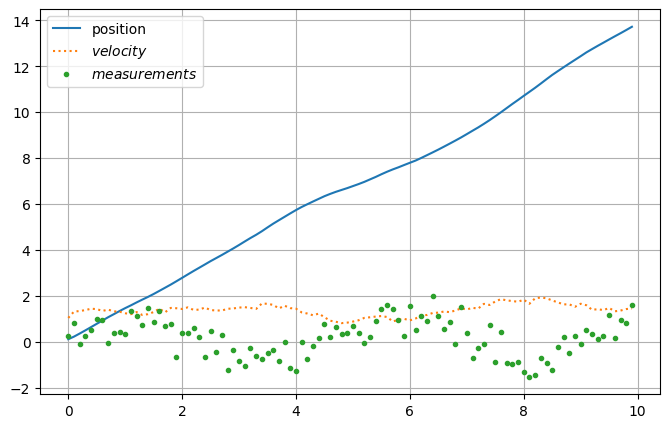

In [10]:
plt.figure(figsize=(8,5))
plt.plot(t_wiener,xs_wiener[:,0], label='position')
plt.plot(t_wiener,xs_wiener[:,1], ':', label='$velocity$')
plt.plot(t_wiener,ys_wiener[:,0],'.', label='$measurements$')
plt.legend()
plt.grid();

### Here, the implementation of EKF is for general nonlinear system  with additive Gaussian noise
$$
x_n = f(x_{n-1}) + q_n\\
$$
$$
y_n = g(x_n) + r_n
$$


In [11]:
def f_fun(x):
    return F_wiener @ x

def F_fun(x):
    return F_wiener

def g_fun(x):
    return np.array([np.sin(x[0])])
 
def G_fun(x):
    return np.array([[np.cos(x[0]), 0.]])


In [12]:
def Extended_Kalman_Filter(f, F, g, G, Q, R, m0, P0, Y):
    T = Y.shape[0]
    nx = m0.shape[0] # dimension of x
    x = np.zeros((T, nx))
    P = np.zeros((T, nx, nx))
    x[0] = m0
    P[0] = P0
    for n in range(T-1):
        # Prediction --> since dynamic model is linear, prediction step is reduced to the prediction step of KF
        x_ = f(x[n])
        F_x = F(x[n])
        P_ = F_x @ P[n] @ F_x.T + Q
        # Update
        G_x = G(x_) # evaluate jacobian at the prediction mean
        S = G_x @ P_ @ G_x.T + R
        K = P_ @ G_x.T @ linalg.inv(S)
        P[n+1] = P_ - K @ S @ K.T
        x[n+1] = x_ + K @ (Y[n] - g(x_))
    return x, P


In [13]:
x_ekf, cov_ekf = Extended_Kalman_Filter(f_fun, F_fun, g_fun, G_fun,Q_wiener,R_wiener, m0, P0, ys_wiener)


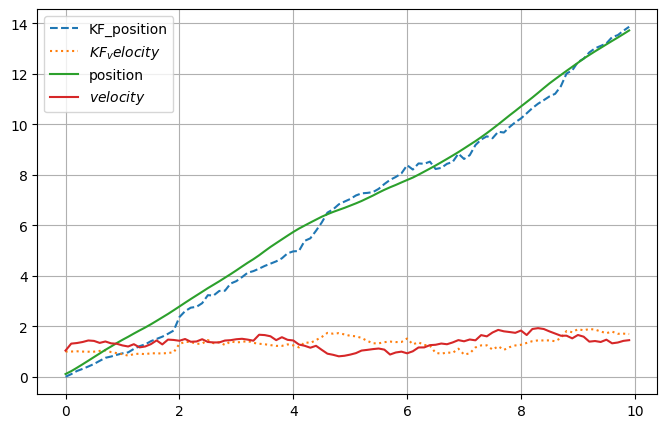

In [14]:
plt.figure(figsize=(8,5))
plt.plot(t_wiener,x_ekf[:,0],'--', label='KF_position')
plt.plot(t_wiener,x_ekf[:,1],':', label='$KF_velocity$')
plt.plot(t_wiener,xs_wiener[:,0], label='position')
plt.plot(t_wiener,xs_wiener[:,1], label='$velocity$')
plt.legend()
plt.grid();

In [15]:
# Lecture 10 page e.g. 23
def unscented_weigths(nx, alpha, beta):
    kappa = 3 - nx
    lam = (nx + kappa)*alpha**2 - nx
    
    WM = np.zeros(2*nx + 1)
    WC = np.zeros(2*nx + 1)
    
    wm_0 = lam / (nx + lam)
    wc_0 = lam / (nx + lam) + (1 - alpha**2 + beta)
    wm = 1 / (2*(nx + lam))
    wc = wm
    
    for j in range(2*nx + 1):
        if j==0:
            WM[j] = wm_0
            WC[j] = wc_0
        else:
            WM[j] = wm
            WC[j] = wc
    
    return lam, WM, WC

def sigma_points(m, P, lam):
    sqrt_P = linalg.cholesky(P, lower=True)
    nx = m.shape[0]
    x_u = np.zeros((2*nx+1,nx))
    x_u[0,:] = m
    for i in range(nx):
        x_u[1 + i,:] = m + np.sqrt(nx + lam) * sqrt_P[:, i]
        x_u[nx + 1 + i,:] = m - np.sqrt(nx + lam) * sqrt_P[:, nx-i-1]

    return x_u


In [16]:
def Unscented_Kalman_Filter(F, g_fun, WM, WC, lam, m0, P0, Q, R, Y):
    T = Y.shape[0]
    nx = m0.shape[0]
    d = nx
    x = np.zeros((T,nx))
    P = np.zeros((T,nx,nx))
    x[0] = m0
    P[0] = P0
    for n in range(T-1):
        #Prediction --> since dynamic model is linear, prediction step is reduced to the prediction step of KF
        x_hat_min = F @ x[n]
        P_min = F @ P[n] @ F.T + Q
        
        #Update
        x_ust = sigma_points(x_hat_min, P_min, lam)
        g_ust = np.zeros((x_ust.shape[0], Y.shape[1]))
        for i in range(x_ust.shape[0]):
            g_ust[i,:] = g_fun(x_ust[i,:])

        # Compute the updated mean and covariance
        mu = np.zeros((g_ust.shape[1],))
        S  = np.zeros((g_ust.shape[1],g_ust.shape[1]))
        C  = np.zeros((x_ust.shape[1],g_ust.shape[1]))
        for i in range(g_ust.shape[0]):
            mu = mu + WM[i] * g_ust[i,:]
        for i in range(g_ust.shape[0]):
            S = S + WC[i] * np.outer(g_ust[i,:] - mu, g_ust[i,:] - mu)
            C = C + WC[i] * np.outer(x_ust[i,:] - x_hat_min, g_ust[i,:] - mu)
        S = S + R
        K = C @ linalg.inv(S)
        P[n+1] = P_min - K @ S @ K.T
        x[n+1] = x_hat_min + K @(Y[n] - mu)        
    return x, P


In [17]:
lam, WM, WC = unscented_weigths(nx=m0.shape[0], alpha=1, beta=0)
x_ukf,P_ukf = Unscented_Kalman_Filter(F_wiener, g_fun, WM, WC, lam,
                                      m0,P0,  Q_wiener,R_wiener, 
                                      ys_wiener)


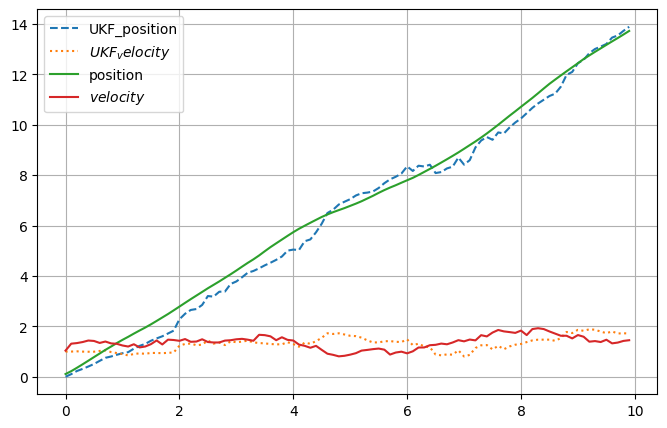

In [18]:
plt.figure(figsize=(8,5))
plt.plot(t_wiener,x_ukf[:,0],'--', label='UKF_position')
plt.plot(t_wiener,x_ukf[:,1],':', label='$UKF_velocity$')
plt.plot(t_wiener,xs_wiener[:,0], label='position')
plt.plot(t_wiener,xs_wiener[:,1], label='$velocity$')
plt.legend()
plt.grid();

# Question 2

## a.
## Robot model (refer to exercise 8 question 3)
$$
\frac{d p^x}{dt} = v cos(\phi) + w_1\\
$$
$$
\frac{d p^y}{dt} = v sin(\phi) + w_2\\
$$
$$
\frac{d \phi}{dt} = w + w_3
$$
## The discrete dynamic model is:
$$
p^x_n = p^x_{n-1} + v_{n-1} cos(\phi_{n-1}) \Delta t + e_1\\
$$
$$
p^y_n = p^y_{n-1} + v_{n-1} sin(\phi_{n-1}) \Delta t + e_2\\
$$
$$
\phi_n = \phi_{n-1} + w_{n-1} \Delta t + e_3
$$
## The measurement model is (we have noisy measurements of positions)
$$
y_1 = p^x + r_1\\
$$
$$
y_2 = p^y + r_2
$$
## We know that $\mathbf{x} = \begin{bmatrix} p^x \\ p^y\\ \phi \end{bmatrix}$ so the compact form of the measurement model is:
$$
\mathbf{y} = G \mathbf{x} + \mathbf{r}\\
$$
$$
\mathbf{y} = \begin{bmatrix}
1 & 0 & 0\\
0 & 1 & 0
\end{bmatrix} \mathbf{x} + \mathbf{r},
$$

 ## b. Simulate states (as in Ex 7)  and measurements

In [19]:
import numpy as np
import matplotlib.pyplot as plt

In [20]:
f_robot = lambda x,u: np.array( [u[0]*np.cos(x[2]), 
                                 u[0]*np.sin(x[2]), 
                                 u[1]] )
x_robot_0 = np.array([0.,0.,0.])
t_robot = np.linspace(0.,5.,501)
dt_robot = t_robot[1]-t_robot[0]

def u(tr):
    ur = np.zeros((t_robot.shape[0],2))
    for n, t in enumerate(tr):
        if 0 <= t < 1:
            u1 = t
            u2 = 0
        if 1 <= t < 2:
            u1 = 1
            u2 = 0
        if 2 <= t < 3:
            u1 = 1
            u2 = math.pi/2
        if 3 <= t < 4:
            u1 = 1
            u2 = 0
        if 4 <= t < 5:
            u1 = 5 - t
            u2 = 0
        ur[n, 0] = u1
        ur[n, 1] = u2
    return ur

In [21]:
def Euler_Maryama_method(func, u, x0, T, w):
    x = np.zeros((len(T),3))
    x[0] = x0
    for n in range(1, len(T)):
        dt = T[n] - T[n-1]
        x[n,:] = x[n-1,:] + func(x[n-1,:], u[n-1,:]) * dt + w[n-1]
    return x


In [22]:
Q_robot = np.diag([1,1,1e-1])
Q_robot_discrete = dt_robot*Q_robot
q_robot = np.random.randn(t_robot.shape[0],3)@np.linalg.cholesky(Q_robot)
q_robot_discrete = np.sqrt(dt_robot)*np.random.randn(t_robot.shape[0],3)@np.linalg.cholesky(Q_robot_discrete)

In [23]:
u_robot = u(t_robot)
x_robot = Euler_Maryama_method(f_robot, u_robot, x_robot_0, t_robot, q_robot_discrete)


In [24]:
def _g_robot(x):
    return np.array([x[0], x[1]])


In [26]:
g_robot = np.vectorize(_g_robot, signature='(n)->(2)') # Instead of looping, we can vectorize
R_robot_discrete = 0.01*np.eye(2)
r_robot = np.random.multivariate_normal(np.zeros(2),R_robot_discrete,(t_robot.shape[0]))

y_robot = g_robot(x_robot) + r_robot # measurement function


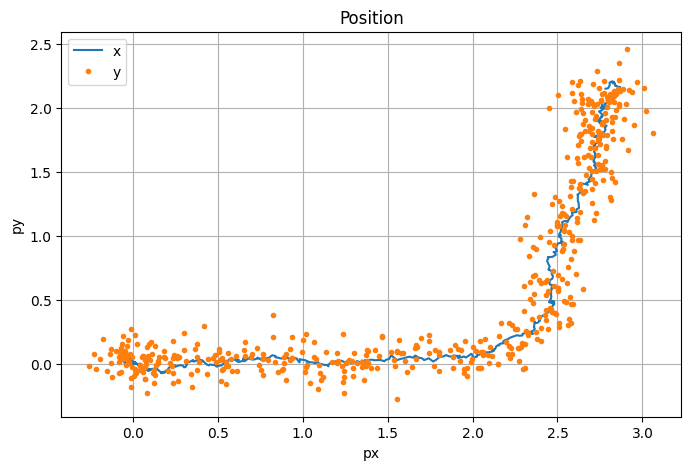

In [27]:
plt.figure(figsize=(8,5))
plt.plot(x_robot[:,0], x_robot[:,1], y_robot[:,0], y_robot[:,1], '.')
plt.xlabel('px')
plt.ylabel('py')
plt.title('Position')
plt.legend(['x','y'])
plt.grid();


In [28]:
# Preparing functions for EKF implementation

f_robot = lambda x,u: np.array( [u[0]*np.cos(x[2]), 
                                 u[0]*np.sin(x[2]), 
                                 u[1]] )
f_robot_discrete = lambda x,u: x + f_robot(x,u)*dt_robot

def F_robot(x, u):
    jac = np.zeros((x.shape[0],x.shape[0]))
    jac[0,2] = -u[0]*np.sin(x[2])
    jac[1,2] = u[0]*np.cos(x[2])
    return jac

def F_robot_discrete(x,u):
    return np.eye(x.shape[0])+F_robot(x,u)*dt_robot

def G_robot(x):
    return np.array([[1,0.,0.],[0.,1.,0.]])


## c) EKF

In [29]:
def Extended_Kalman_Filter_u(f, F, g, G, Q, R, m0, P0, Y, u):
    T = Y.shape[0]
    nx = m0.shape[0] # dimension of x
    x = np.zeros((T, nx))
    P = np.zeros((T, nx, nx))
    x[0] = m0
    P[0] = P0
    for n in range(T-1):
        # Prediction
        x_ = f(x[n], u[n])
        F_x = F(x[n], u[n])
        P_ = F_x @ P[n] @ F_x.T + Q
        # Update
        G_x = G(x_)
        S = G_x @ P_@ G_x.T + R
        K = P_ @ G_x.T @ linalg.inv(S)
        P[n+1] = P_ - K @ S @ K.T
        x[n+1] = x_ + K @ (Y[n] - g(x_))
    return x, P

In [30]:
P0_robot = 0.1**2 * np.eye(3)
x_ekf_robot, cov_ekf_robot = Extended_Kalman_Filter_u(f_robot_discrete,
                                                    F_robot_discrete,
                                                    _g_robot,
                                                    G_robot,
                                                    Q_robot_discrete,
                                                    R_robot_discrete,
                                                    x_robot_0, 
                                                    P0_robot,
                                                    y_robot, 
                                                    u_robot)


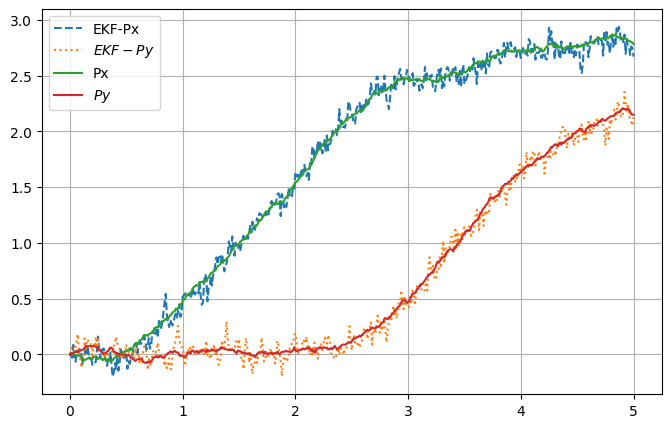

In [31]:
plt.figure(figsize=(8,5))
plt.plot(t_robot,x_ekf_robot[:,0],'--', label='EKF-Px')
plt.plot(t_robot,x_ekf_robot[:,1],':', label='$EKF-Py$')
plt.plot(t_robot,x_robot[:,0], label='Px')
plt.plot(t_robot,x_robot[:,1], label='$Py$')
plt.legend()
plt.grid();

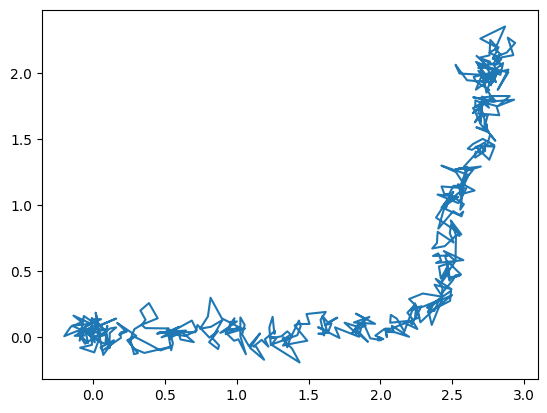

In [32]:
plt.plot(x_ekf_robot[:,0], x_ekf_robot[:,1]);

# Question 3

## The discrete dynamic model is:
$$
p^x_n = p^x_{n-1} + v_{n-1} cos(\phi_{n-1}) \Delta t + e_1\\
$$
$$
p^y_n = p^y_{n-1} + v_{n-1} sin(\phi_{n-1}) \Delta t + e_2\\
$$
$$
\phi_n = \phi_{n-1} + w_{n-1} \Delta t + e_3
$$
## The measurement model is:
$$
y_1 = \sqrt{(x_1 - s_x)^2 + (x_2 - s_y)^2} + r_1 \\
$$
$$
y_2 = \arctan{\frac{x_2 - s_y}{x_1 - s_x}} - \phi + r_2
$$

In [33]:
import numpy as np
import scipy.linalg as linalg
import math
import matplotlib.pyplot as plt

sx = 1
sy = 1.5
x_robot_0 = np.array([0.,0.,0.])
t_robot_2 = np.linspace(0.,5.,51)
dt_robot_2 = t_robot_2[1]-t_robot_2[0]


f_robot_2 = lambda x,u: np.array( [u[0]*np.cos(x[2]), 
                                 u[0]*np.sin(x[2]), 
                                 u[1]] )
f_robot_discrete_2 = lambda x,u: x + f_robot_2(x,u)*dt_robot_2

def F_robot_2(x, u):
    jac = np.zeros((x.shape[0],x.shape[0]))
    jac[0,2] = -u[0]*np.sin(x[2])
    jac[1,2] = u[0]*np.cos(x[2])
    return jac

def F_robot_discrete_2(x,u):
    return np.eye(x.shape[0]) + F_robot_2(x,u)*dt_robot_2

# You need to use arctan2 which considers the signs of the inputs in order to return the appropriate quadrant of the computed angle
def _g_robot_2(x):
    return np.array([np.sqrt((x[0]-sx)**2 + (x[1]-sy)**2),
                     np.arctan2(sy-x[1],sx-x[0])-x[2]])


g_robot_2 = np.vectorize(_g_robot_2, signature='(n)->(2)') ##Vectorize the stuff to avoid doing looping


def G_robot_2(x):
    return np.array([[(x[0]-sx)/np.sqrt((x[0]-sx)**2 + (x[1]-sy)**2),(x[1]-sy)/np.sqrt((x[0]-sx)**2 + (x[1]-sy)**2),0],
                    [(sy-x[1])/((x[0]-sx)**2 + (x[1]-sy)**2),(x[0]-sx)/((x[0]-sx)**2 + (x[1]-sy)**2),-1]])





In [34]:
# You can check the Jacobian using autodiff
import autograd.numpy as anp   # Thinly-wrapped version of Numpy # install it: pip install autograd
from autograd import jacobian

def ag_fun(x):
    return anp.array([anp.sqrt((x[0]-sx)**2 + (x[1]-sy)**2), anp.arctan2(sy-x[1],sx-x[0])-x[2]])

x = np.random.normal(size=(3,))
J1 = G_robot_2(x)
J2 = jacobian(ag_fun)(x)
print(J1)
print(J2)
print(linalg.norm(J1 - J2))

[[-0.69774441 -0.7163468   0.        ]
 [ 0.42383204 -0.4128258  -1.        ]]
[[-0.69774441 -0.7163468   0.        ]
 [ 0.42383204 -0.4128258  -1.        ]]
1.1102230246251565e-16


In [35]:
def Euler_Maryama_method(func, u, x0, T, w):
    x = np.zeros((len(T),3))
    x[0] = x0
    for n in range(1, len(T)):
        dt = T[n] - T[n-1]
        x[n,:] = x[n-1,:] + func(x[n-1,:], u[n-1,:]) * dt + w[n-1]
    return x

In [36]:
def u(tr):
    ur = np.zeros((t_robot_2.shape[0],2))
    for n, t in enumerate(tr):
        if 0 <= t < 1:
            u1 = t
            u2 = 0
        if 1 <= t < 2:
            u1 = 1
            u2 = 0
        if 2 <= t < 3:
            u1 = 1
            u2 = math.pi/2
        if 3 <= t < 4:
            u1 = 1
            u2 = 0
        if 4 <= t < 5:
            u1 = 5 - t
            u2 = 0
        ur[n, 0] = u1
        ur[n, 1] = u2
    return ur


In [37]:
Q_robot = np.diag([1,1,1e-1])
Q_robot_discrete = dt_robot_2*Q_robot
q_robot = np.random.randn(t_robot_2.shape[0],3)@np.linalg.cholesky(Q_robot)
q_robot_discrete = np.sqrt(dt_robot_2)*np.random.randn(t_robot_2.shape[0],3)@np.linalg.cholesky(Q_robot_discrete)
u_robot = u(t_robot_2)
# Dynamic model
x_robot_2 = Euler_Maryama_method(f_robot_2, u_robot, x_robot_0, t_robot_2, q_robot_discrete)

R_robot_discrete = 0.01*np.eye(2)
r_robot = np.random.multivariate_normal(np.zeros(2),R_robot_discrete,(t_robot_2.shape[0]))
# measurement model
y_robot_2 = g_robot_2(x_robot_2) + r_robot


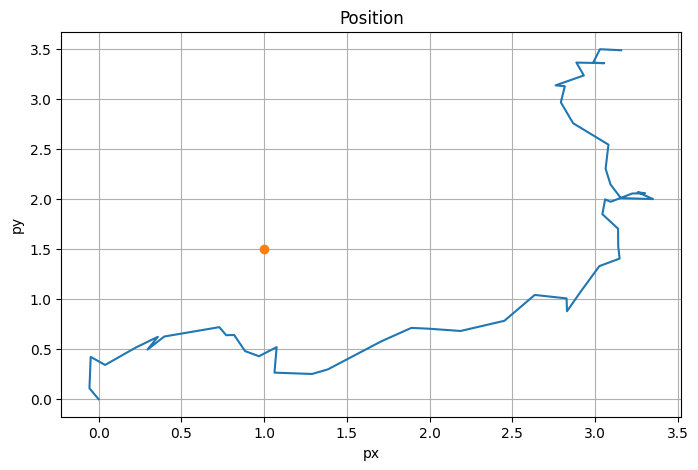

In [38]:
plt.figure(figsize=(8,5))
plt.plot(x_robot_2[:,0],x_robot_2[:,1],sx,sy,'o')
plt.xlabel('px')
plt.ylabel('py')
plt.title('Position')
plt.grid();

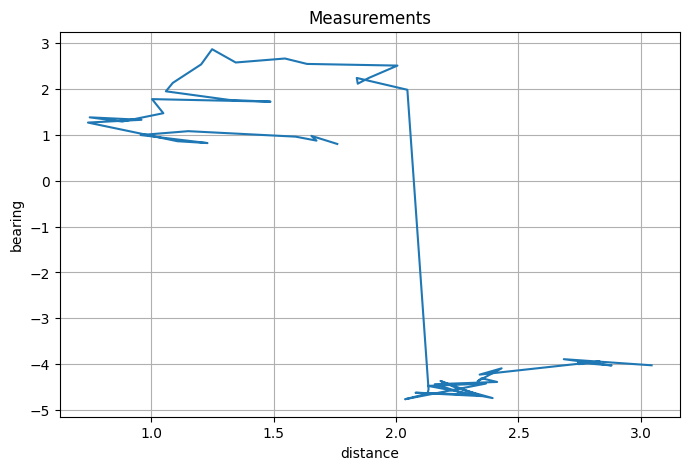

In [39]:
plt.figure(figsize=(8,5))
plt.plot(y_robot_2[:,0],y_robot_2[:,1])
plt.xlabel('distance')
plt.ylabel('bearing')
plt.title('Measurements')
plt.grid();

In [40]:
def Extended_Kalman_Filter_u(f, F, g, G, Q, R, m0, P0, Y, u):
    T = Y.shape[0]
    nx = m0.shape[0] # dimension of x
    x = np.zeros((T, nx))
    P = np.zeros((T, nx, nx))
    x[0] = m0
    P[0] = P0
    for n in range(T-1):
        # Prediction
        x_ = f(x[n], u[n])
        F_x = F(x[n], u[n])
        P_ = F_x @ P[n] @ F_x.T + Q
        # Update
        G_x = G(x_)
        S = G_x @ P_@ G_x.T + R
        K = P_ @ G_x.T @ linalg.inv(S)
        
        res = Y[n] - g(x_)
        # arctan2 is a discontinuous function, when its argument is greater than pi, it jumps to -pi
        # note that this is just for this bearing model (it does not related to ekf implementation)
        if res[1] > np.pi:
            res[1] = res[1] - 2*np.pi
        elif res[1] < -np.pi:
            res[1] = res[1] + 2*np.pi
        
        P[n+1] = P_ - K @ S @ K.T
        x[n+1] = x_ + K @ res
    return x, P

x_ekf_robot_2, cov_ekf_robot_2 = Extended_Kalman_Filter_u(f_robot_discrete_2,
                                                          F_robot_discrete_2,
                                                          _g_robot_2,
                                                          G_robot_2,
                                                          Q_robot_discrete,
                                                          R_robot_discrete,
                                                          x_robot_0,
                                                          Q_robot_discrete,
                                                          y_robot_2, 
                                                          u_robot)


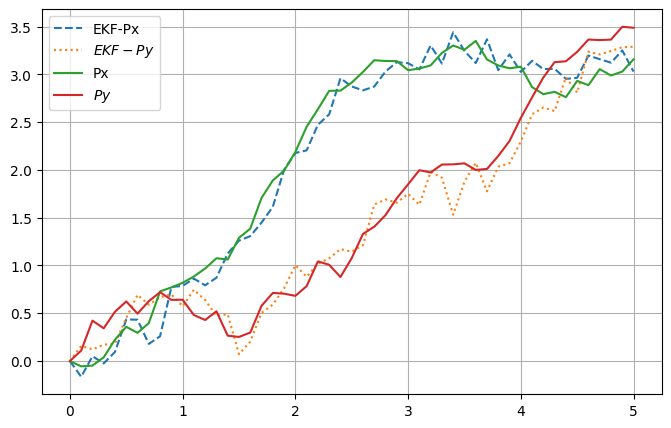

In [41]:
plt.figure(figsize=(8,5))
plt.plot(t_robot_2,x_ekf_robot_2[:,0],'--', label='EKF-Px')
plt.plot(t_robot_2,x_ekf_robot_2[:,1],':', label='$EKF-Py$')
plt.plot(t_robot_2,x_robot_2[:,0], label='Px')
plt.plot(t_robot_2,x_robot_2[:,1], label='$Py$')
plt.legend()
plt.grid();

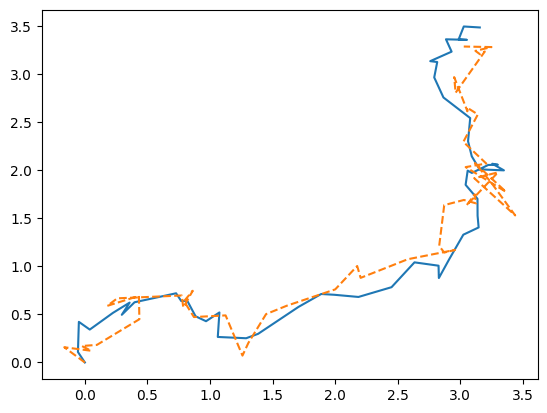

In [42]:
plt.plot(x_robot_2[:,0],x_robot_2[:,1],x_ekf_robot_2[:,0],x_ekf_robot_2[:,1],'--');